<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/3_AutoRegressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uni- vs. Multivariate Autoregressive Model

In [3]:
import pandas as pd

localurl = "./timeseries_data/normalized_data_multivariate_DOWNLOADED.csv"
dataframe = pd.read_csv(localurl,parse_dates=["datetime"])
dataframe.head(20)

,longitude,latitude,station_code,datetime,o3,no2,no,temp,press
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.566220,-337.675195
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.633418,-337.675195
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.646857,-337.675195
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.740934,-337.675195
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.767813,-337.675195
5,6.093923,50.754704,DENW094,1997-01-01 05:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.727494,-337.675195
6,6.093923,50.754704,DENW094,1999-07-05 15:00:00+00:00,1.706701,0.374967,0.409565,1.520635,-0.070334
7,6.093923,50.754704,DENW094,1999-07-05 15:00:00+00:00,1.771692,0.392283,0.409565,1.547514,-0.070334
8,6.093923,50.754704,DENW094,1999-07-05 16:00:00+00:00,1.836683,0.409430,0.409565,1.574393,-0.070334
9,6.093923,50.754704,DENW094,1999-07-05 16:00:00+00:00,1.846945,0.426413,0.409565,1.601272,-0.070334


In [4]:
dataframe.shape

(700846, 9)

## Updated Data Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Parameters for forecasting
context_window = 336  # 14 days of hourly data for context
prediction_horizon = 96  # 4 days ahead prediction

print("=== SARIMAX Time Series Forecasting ===")
print(f"Context window: {context_window} hours (14 days)")
print(f"Prediction horizon: {prediction_horizon} hours (4 days)")

# Prepare data for DENW094 station
station_data = dataframe[dataframe['station_code'] == 'DENW094'].copy()
station_data = station_data.sort_values('datetime').reset_index(drop=True)

print(f"\nStation DENW094 data shape: {station_data.shape}")
print(f"Date range: {station_data['datetime'].min()} to {station_data['datetime'].max()}")

# Find a good continuous section for analysis
# Let's find sections with minimal gaps
station_data['time_diff'] = station_data['datetime'].diff()
hourly_gaps = station_data['time_diff'] == pd.Timedelta(hours=1)

print(f"Percentage of 1-hour gaps: {hourly_gaps.mean()*100:.1f}%")

# Find a suitable starting point with good data quality
# Let's look for a section in the middle of the dataset with good continuity
mid_point = len(station_data) // 2
search_start = max(0, mid_point - 5000)
search_end = min(len(station_data), mid_point + 5000)

best_start = search_start
max_continuous = 0

# Find the longest continuous stretch in the search area
for start_idx in range(search_start, search_end - (context_window + prediction_horizon)):
    end_idx = start_idx + context_window + prediction_horizon
    section = station_data.iloc[start_idx:end_idx]
    
    if len(section) == context_window + prediction_horizon:
        time_span = (section['datetime'].iloc[-1] - section['datetime'].iloc[0]).total_seconds() / 3600
        expected_span = context_window + prediction_horizon - 1
        
        # Allow some flexibility but prefer closer to ideal
        if time_span <= expected_span * 1.2:  # Allow 20% extra time for some gaps
            continuous_score = expected_span / time_span  # Higher is better
            if continuous_score > max_continuous:
                max_continuous = continuous_score
                best_start = start_idx

print(f"Selected data starting at index {best_start}")
print(f"Continuity score: {max_continuous:.3f} (1.0 = perfect)")

# Extract the selected section
selected_data = station_data.iloc[best_start:best_start + context_window + prediction_horizon].copy()
print(f"Selected section: {selected_data['datetime'].iloc[0]} to {selected_data['datetime'].iloc[-1]}")

# Split into context and prediction periods
context_data = selected_data.iloc[:context_window]
future_data = selected_data.iloc[context_window:]

print(f"Context period: {context_data['datetime'].iloc[0]} to {context_data['datetime'].iloc[-1]}")
print(f"Prediction period: {future_data['datetime'].iloc[0]} to {future_data['datetime'].iloc[-1]}")

# Prepare series for modeling
temp_series = context_data['temp'].values
actual_future = future_data['temp'].values

# For multivariate model, prepare exogenous variables
exog_context = context_data[['o3']].values # 'o3', 'no2', 'no', 'press'
exog_future = future_data[['o3']].values # 'o3', 'no2', 'no', 'press'

print(f"\nO3 series length: {len(temp_series)}")
print(f"Actual future length: {len(actual_future)}")
print(f"Exogenous variables shape: {exog_context.shape}")

=== SARIMAX Time Series Forecasting ===
Context window: 336 hours (14 days)
Prediction horizon: 96 hours (4 days)

Station DENW094 data shape: (700846, 9)
Date range: 1997-01-01 00:00:00+00:00 to 2024-01-01 01:00:00+00:00
Percentage of 1-hour gaps: 21.0%
Selected data starting at index 350775
Continuity score: 4.954 (1.0 = perfect)
Selected section: 2015-06-19 05:00:00+00:00 to 2015-06-22 20:00:00+00:00
Context period: 2015-06-19 05:00:00+00:00 to 2015-06-22 01:00:00+00:00
Prediction period: 2015-06-22 01:00:00+00:00 to 2015-06-22 20:00:00+00:00

O3 series length: 336
Actual future length: 96
Exogenous variables shape: (336, 1)


### Forecasting Both Variants


=== Univariate SARIMAX (Temp only) ===
ADF p-value for O3: 0.064333
Using differencing parameter d = 1
Fitting univariate SARIMAX model...
Univariate SARIMAX - MSE: 0.0229, RMSE: 0.1513
AIC: -954.38

=== Multivariate SARIMAX (O3 + Temperature + Other variables) ===
Multivariate SARIMAX - MSE: 0.0121, RMSE: 0.1102
AIC: -1006.24

=== Plotting Results ===


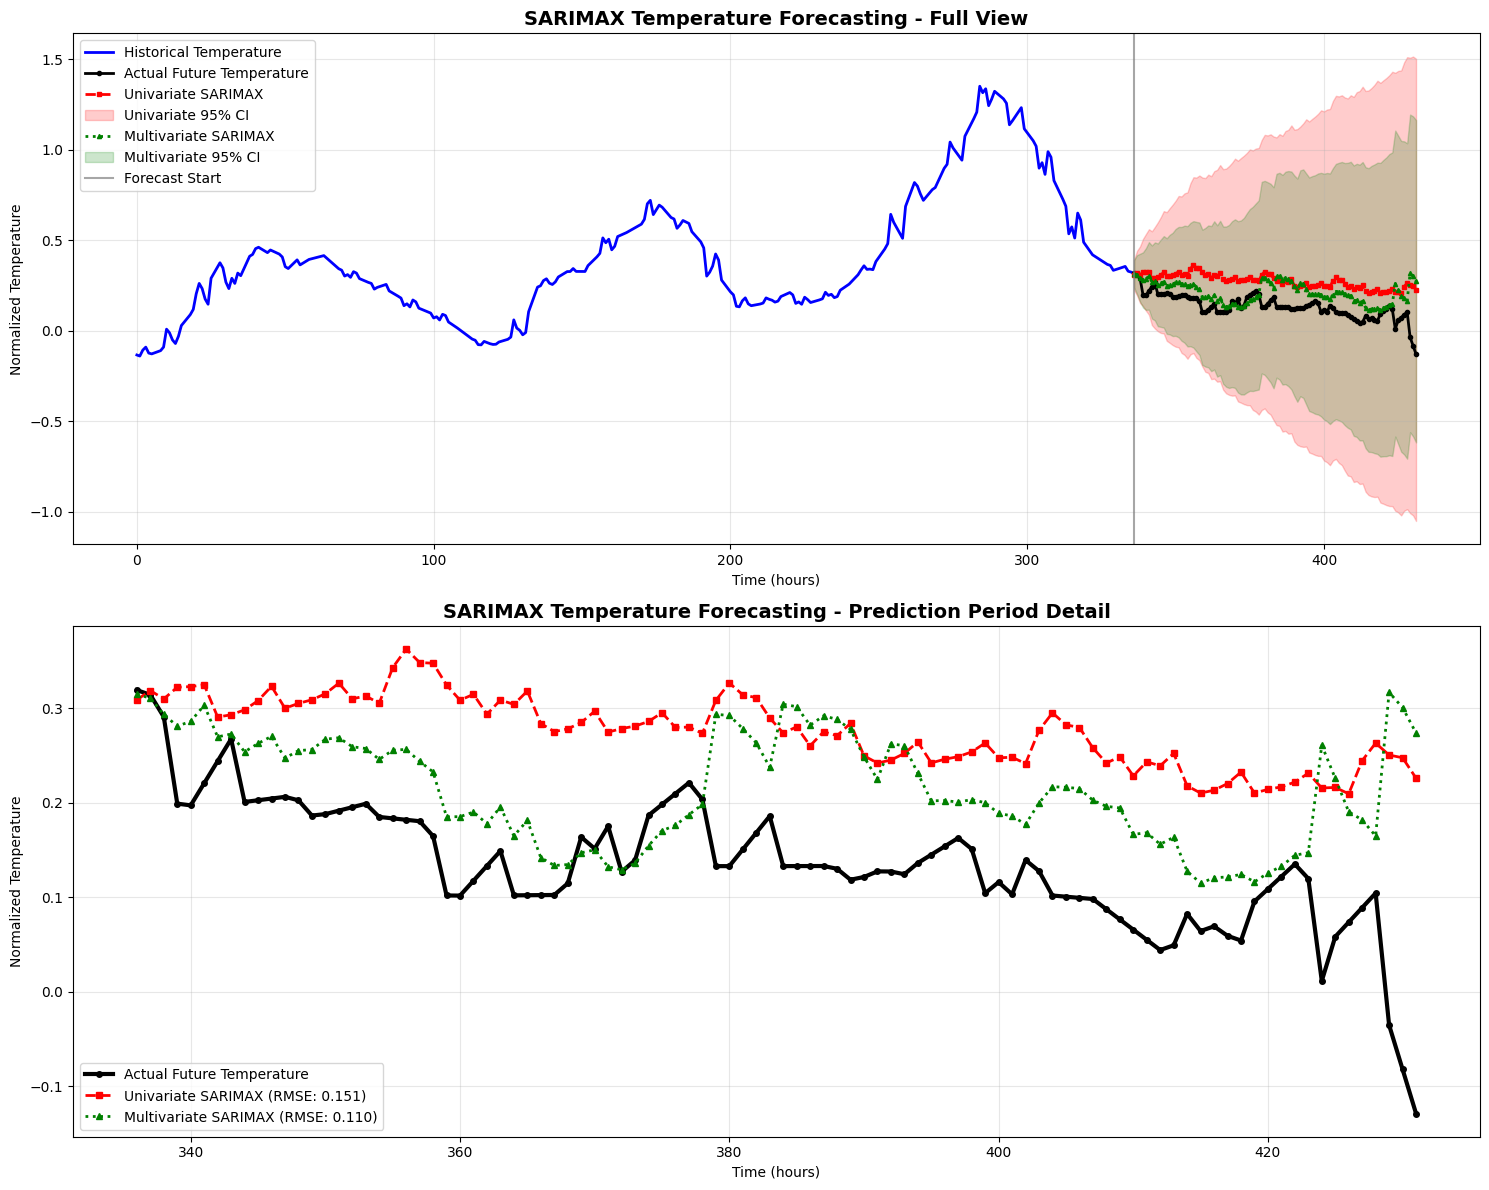


=== Model Comparison Summary ===
               Model        Variables    MSE   RMSE      AIC
  Univariate SARIMAX        Temp only 0.0229 0.1513  -954.38
Multivariate SARIMAX O3 + Temperature 0.0121 0.1102 -1006.24

Multivariate model RMSE improvement: 27.19%


In [13]:
# === UNIVARIATE SARIMAX MODEL ===
print("\n=== Univariate SARIMAX (Temp only) ===")

# Check stationarity
adf_test = adfuller(temp_series)
p_value = adf_test[1]
print(f"ADF p-value for O3: {p_value:.6f}")

# Determine differencing
d = 0 if p_value < 0.05 else 1
seasonal_period = 24  # Daily seasonality for hourly data

print(f"Using differencing parameter d = {d}")
print("Fitting univariate SARIMAX model...")

try:
    # Fit univariate SARIMAX model for Temp
    univariate_model = SARIMAX(
        temp_series,
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast
    univariate_forecast = univariate_model.get_forecast(steps=prediction_horizon)
    univariate_pred = univariate_forecast.predicted_mean
    univariate_ci = univariate_forecast.conf_int()
    
    # Calculate metrics
    univariate_mse = mean_squared_error(actual_future, univariate_pred)
    univariate_rmse = np.sqrt(univariate_mse)
    
    print(f"Univariate SARIMAX - MSE: {univariate_mse:.4f}, RMSE: {univariate_rmse:.4f}")
    print(f"AIC: {univariate_model.aic:.2f}")
    
    univariate_success = True
    
except Exception as e:
    print(f"Univariate model failed: {e}")
    univariate_success = False

# === MULTIVARIATE SARIMAX MODEL ===
print("\n=== Multivariate SARIMAX (O3 + Temperature + Other variables) ===")

try:
    # Fit multivariate SARIMAX model with exogenous variables
    multivariate_model = SARIMAX(
        temp_series,  # temp is now the target
        exog=exog_context,  # O3, NO2, NO, Pressure as exogenous
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecast with exogenous variables
    multivariate_forecast = multivariate_model.get_forecast(
        steps=prediction_horizon, 
        exog=exog_future
    )
    multivariate_pred = multivariate_forecast.predicted_mean
    multivariate_ci = multivariate_forecast.conf_int()
    
    # Calculate metrics
    multivariate_mse = mean_squared_error(actual_future, multivariate_pred)
    multivariate_rmse = np.sqrt(multivariate_mse)
    
    print(f"Multivariate SARIMAX - MSE: {multivariate_mse:.4f}, RMSE: {multivariate_rmse:.4f}")
    print(f"AIC: {multivariate_model.aic:.2f}")
    
    multivariate_success = True
    
except Exception as e:
    print(f"Multivariate model failed: {e}")
    multivariate_success = False

# === PLOTTING RESULTS ===
print("\n=== Plotting Results ===")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Time indices for plotting
context_time = np.arange(context_window)
future_time = np.arange(context_window, context_window + prediction_horizon)

# Plot 1: Full comparison
ax1.plot(context_time, temp_series, label="Historical Temperature", color="blue", linewidth=2)
ax1.plot(future_time, actual_future, label="Actual Future Temperature", color="black", linewidth=2, marker='o', markersize=3)

if univariate_success:
    ax1.plot(future_time, univariate_pred, label="Univariate SARIMAX", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=3)
    # Handle confidence intervals - they might be DataFrame or array
    if hasattr(univariate_ci, 'iloc'):
        ax1.fill_between(future_time, univariate_ci.iloc[:, 0], univariate_ci.iloc[:, 1], 
                         color="red", alpha=0.2, label="Univariate 95% CI")
    else:
        ax1.fill_between(future_time, univariate_ci[:, 0], univariate_ci[:, 1], 
                         color="red", alpha=0.2, label="Univariate 95% CI")

if multivariate_success:
    ax1.plot(future_time, multivariate_pred, label="Multivariate SARIMAX", 
             color="green", linestyle=":", linewidth=2, marker='^', markersize=3)
    # Handle confidence intervals - they might be DataFrame or array
    if hasattr(multivariate_ci, 'iloc'):
        ax1.fill_between(future_time, multivariate_ci.iloc[:, 0], multivariate_ci.iloc[:, 1], 
                         color="green", alpha=0.2, label="Multivariate 95% CI")
    else:
        ax1.fill_between(future_time, multivariate_ci[:, 0], multivariate_ci[:, 1], 
                         color="green", alpha=0.2, label="Multivariate 95% CI")

ax1.axvline(x=context_window, color='gray', linestyle='-', alpha=0.7, label="Forecast Start")
ax1.set_title("SARIMAX Temperature Forecasting - Full View", fontsize=14, fontweight='bold')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Normalized Temperature")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed in on prediction period
ax2.plot(future_time, actual_future, label="Actual Future Temperature", color="black", linewidth=3, marker='o', markersize=4)

if univariate_success:
    ax2.plot(future_time, univariate_pred, label=f"Univariate SARIMAX (RMSE: {univariate_rmse:.3f})", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=4)

if multivariate_success:
    ax2.plot(future_time, multivariate_pred, label=f"Multivariate SARIMAX (RMSE: {multivariate_rmse:.3f})", 
             color="green", linestyle=":", linewidth=2, marker='^', markersize=4)

ax2.set_title("SARIMAX Temperature Forecasting - Prediction Period Detail", fontsize=14, fontweight='bold')
ax2.set_xlabel("Time (hours)")
ax2.set_ylabel("Normalized Temperature")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === SUMMARY TABLE ===
print("\n=== Model Comparison Summary ===")
results_summary = []

if univariate_success:
    results_summary.append({
        'Model': 'Univariate SARIMAX',
        'Variables': 'Temp only',
        'MSE': f"{univariate_mse:.4f}",
        'RMSE': f"{univariate_rmse:.4f}",
        'AIC': f"{univariate_model.aic:.2f}"
    })

if multivariate_success:
    results_summary.append({
        'Model': 'Multivariate SARIMAX', 
        'Variables': 'O3 + Temperature',
        'MSE': f"{multivariate_mse:.4f}",
        'RMSE': f"{multivariate_rmse:.4f}",
        'AIC': f"{multivariate_model.aic:.2f}"
    })

if results_summary:
    summary_df = pd.DataFrame(results_summary)
    print(summary_df.to_string(index=False))
    
    if univariate_success and multivariate_success:
        improvement = ((univariate_rmse - multivariate_rmse) / univariate_rmse) * 100
        print(f"\nMultivariate model RMSE improvement: {improvement:.2f}%")
else:
    print("No models succeeded - check data quality and parameters")



=== CASCADED O3 FORECASTING ===
Step 1: Temperature prediction (already done above)
Step 2: Using predicted temperature to forecast O3
O3 context series length: 336
Actual future O3 length: 96

=== Baseline: Univariate O3 Model ===
O3 ADF p-value: 0.022020, using d = 0
O3 Univariate RMSE: 0.3322

=== Standard Multivariate: O3 with KNOWN future temperature ===
O3 Standard Multivariate RMSE: 0.3250

=== CASCADED: O3 with PREDICTED temperature ===
multivariate_pred type: <class 'numpy.ndarray'>
multivariate_pred shape: (96,)
Using predicted temperature with shape: (96, 1)
Predicted temp range: [0.1150, 0.3169]
O3 Cascaded RMSE: 0.3446

=== O3 FORECASTING COMPARISON ===
               Method         Description   RMSE    MSE
        Univariate O3             O3 only 0.3322 0.1103
Standard Multivariate     O3 + KNOWN temp 0.3250 0.1056
    Cascaded Approach O3 + PREDICTED temp 0.3446 0.1188

Cascaded vs Univariate RMSE improvement: -3.75%
Cascaded vs Standard degradation: 6.06%

=== Plotti

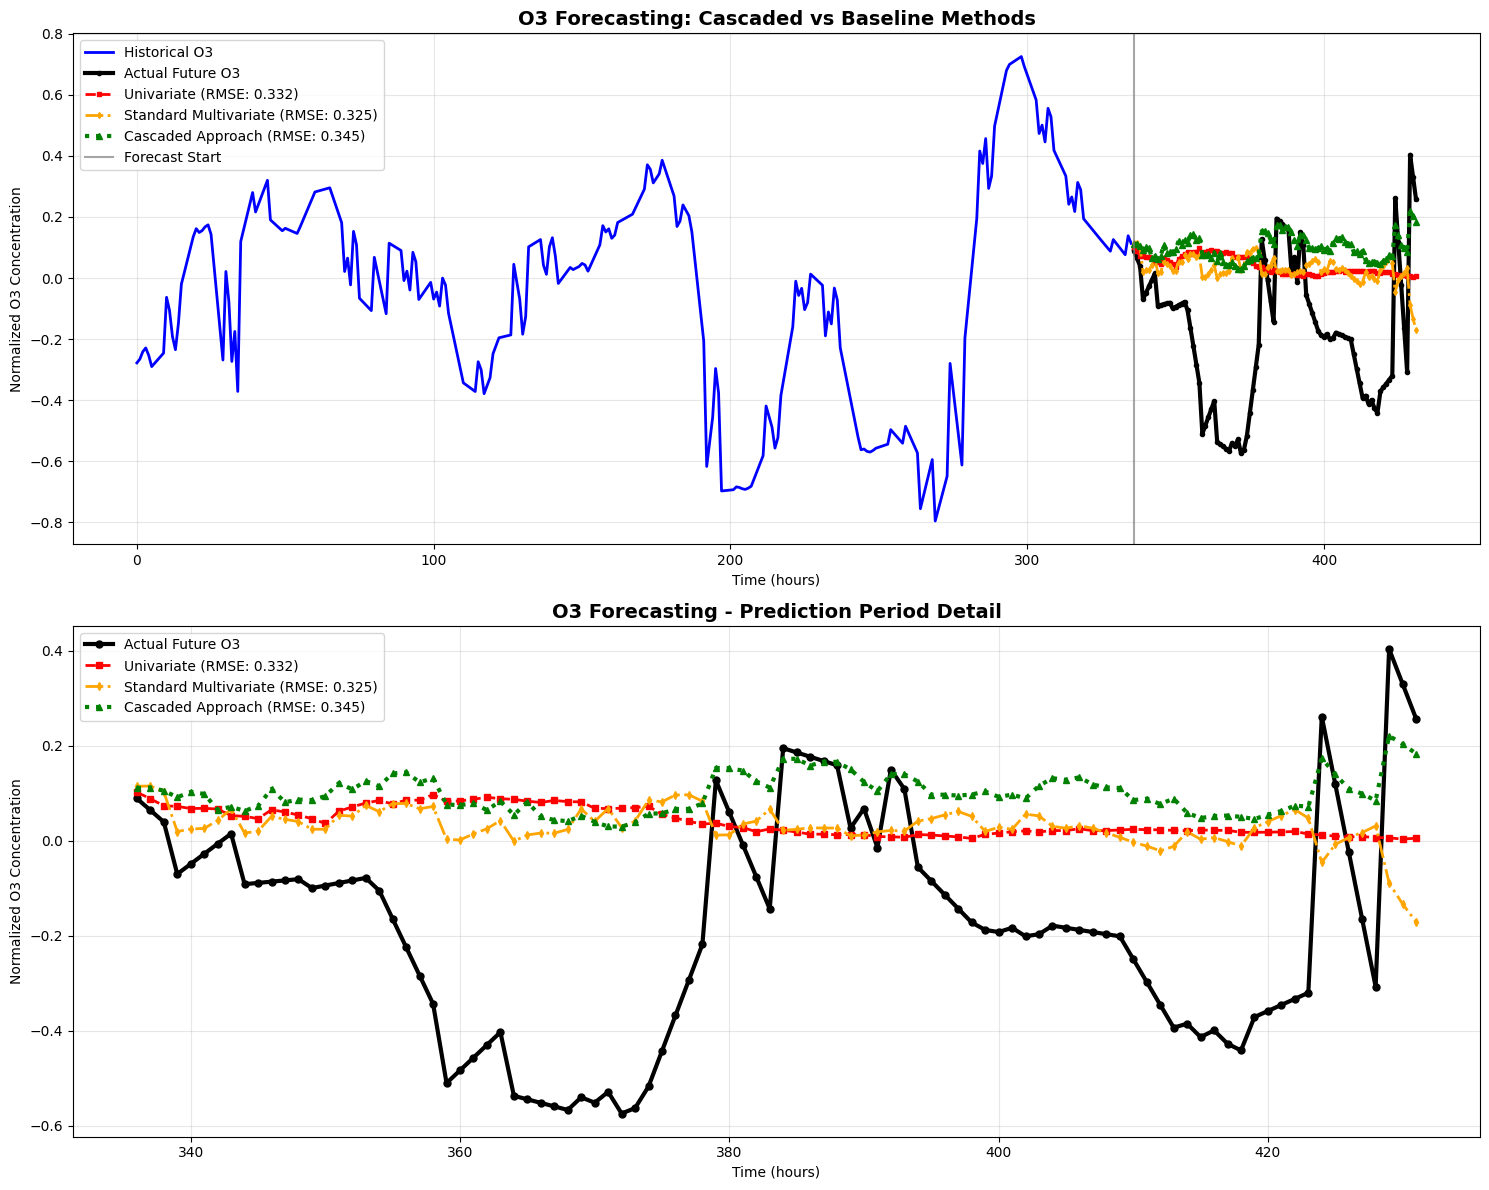


=== CASCADED FORECASTING SUMMARY ===
✓ Step 1: Temperature prediction using O3 as exogenous variable
✓ Step 2: O3 prediction using forecasted temperature

This approach demonstrates how cascaded forecasting can work in practice,
where one model's predictions become inputs for another model.
The cascaded approach has 3.8% degradation vs univariate, but this is expected due to error propagation.
In practice, this approach is valuable when you have access to temperature forecasts.


In [10]:
# === CASCADED O3 FORECASTING USING PREDICTED TEMPERATURE ===
print("\n=== CASCADED O3 FORECASTING ===")
print("Step 1: Temperature prediction (already done above)")
print("Step 2: Using predicted temperature to forecast O3")

# Prepare O3 data for forecasting
o3_series = context_data['o3'].values
actual_future_o3 = future_data['o3'].values

print(f"O3 context series length: {len(o3_series)}")
print(f"Actual future O3 length: {len(actual_future_o3)}")

# === BASELINE: UNIVARIATE O3 MODEL ===
print("\n=== Baseline: Univariate O3 Model ===")
try:
    # Check stationarity for O3
    adf_test_o3 = adfuller(o3_series)
    p_value_o3 = adf_test_o3[1]
    d_o3 = 0 if p_value_o3 < 0.05 else 1
    print(f"O3 ADF p-value: {p_value_o3:.6f}, using d = {d_o3}")
    
    # Univariate O3 model
    o3_univariate_model = SARIMAX(
        o3_series,
        order=(1, d_o3, 1),
        seasonal_order=(1, d_o3, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    o3_univariate_forecast = o3_univariate_model.get_forecast(steps=prediction_horizon)
    o3_univariate_pred = o3_univariate_forecast.predicted_mean
    
    o3_univariate_mse = mean_squared_error(actual_future_o3, o3_univariate_pred)
    o3_univariate_rmse = np.sqrt(o3_univariate_mse)
    
    print(f"O3 Univariate RMSE: {o3_univariate_rmse:.4f}")
    o3_univariate_success = True
    
except Exception as e:
    print(f"O3 Univariate model failed: {e}")
    o3_univariate_success = False

# === STANDARD MULTIVARIATE: O3 with KNOWN future temperature ===
print("\n=== Standard Multivariate: O3 with KNOWN future temperature ===")
try:
    # Use actual future temperature (this is the "oracle" case)
    actual_temp_context = context_data[['temp']].values
    actual_temp_future = future_data[['temp']].values
    
    o3_standard_model = SARIMAX(
        o3_series,
        exog=actual_temp_context,
        order=(1, d_o3, 1),
        seasonal_order=(1, d_o3, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    o3_standard_forecast = o3_standard_model.get_forecast(
        steps=prediction_horizon,
        exog=actual_temp_future
    )
    o3_standard_pred = o3_standard_forecast.predicted_mean
    
    o3_standard_mse = mean_squared_error(actual_future_o3, o3_standard_pred)
    o3_standard_rmse = np.sqrt(o3_standard_mse)
    
    print(f"O3 Standard Multivariate RMSE: {o3_standard_rmse:.4f}")
    o3_standard_success = True
    
except Exception as e:
    print(f"O3 Standard model failed: {e}")
    o3_standard_success = False

# === CASCADED APPROACH: O3 with PREDICTED temperature ===
print("\n=== CASCADED: O3 with PREDICTED temperature ===")

if multivariate_success:
    try:
        # Debug the predicted temperature data type and shape
        print(f"multivariate_pred type: {type(multivariate_pred)}")
        print(f"multivariate_pred shape: {multivariate_pred.shape}")
        
        # Use predicted temperature from Step 1 - handle different data types
        if hasattr(multivariate_pred, 'values'):
            # If it's a pandas Series
            predicted_temp_future = multivariate_pred.values.reshape(-1, 1)
        else:
            # If it's already a numpy array
            predicted_temp_future = multivariate_pred.reshape(-1, 1)
        
        print(f"Using predicted temperature with shape: {predicted_temp_future.shape}")
        print(f"Predicted temp range: [{predicted_temp_future.min():.4f}, {predicted_temp_future.max():.4f}]")
        
        # Train O3 model with historical temperature
        o3_cascaded_model = SARIMAX(
            o3_series,
            exog=actual_temp_context,
            order=(1, d_o3, 1),
            seasonal_order=(1, d_o3, 1, 24),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        # Forecast O3 using predicted temperature
        o3_cascaded_forecast = o3_cascaded_model.get_forecast(
            steps=prediction_horizon,
            exog=predicted_temp_future
        )
        o3_cascaded_pred = o3_cascaded_forecast.predicted_mean
        
        o3_cascaded_mse = mean_squared_error(actual_future_o3, o3_cascaded_pred)
        o3_cascaded_rmse = np.sqrt(o3_cascaded_mse)
        
        print(f"O3 Cascaded RMSE: {o3_cascaded_rmse:.4f}")
        o3_cascaded_success = True
        
    except Exception as e:
        print(f"O3 Cascaded model failed: {e}")
        import traceback
        traceback.print_exc()
        o3_cascaded_success = False
else:
    print("Cannot run cascaded approach - temperature prediction failed")
    o3_cascaded_success = False

# === COMPARISON AND VISUALIZATION ===
print("\n=== O3 FORECASTING COMPARISON ===")

# Create comparison table
o3_results = []
if o3_univariate_success:
    o3_results.append({
        'Method': 'Univariate O3',
        'Description': 'O3 only',
        'RMSE': f"{o3_univariate_rmse:.4f}",
        'MSE': f"{o3_univariate_mse:.4f}"
    })

if o3_standard_success:
    o3_results.append({
        'Method': 'Standard Multivariate',
        'Description': 'O3 + KNOWN temp',
        'RMSE': f"{o3_standard_rmse:.4f}",
        'MSE': f"{o3_standard_mse:.4f}"
    })

if o3_cascaded_success:
    o3_results.append({
        'Method': 'Cascaded Approach',
        'Description': 'O3 + PREDICTED temp',
        'RMSE': f"{o3_cascaded_rmse:.4f}",
        'MSE': f"{o3_cascaded_mse:.4f}"
    })

if o3_results:
    o3_comparison_df = pd.DataFrame(o3_results)
    print(o3_comparison_df.to_string(index=False))

# Calculate improvements
if o3_univariate_success and o3_cascaded_success:
    cascaded_improvement = ((o3_univariate_rmse - o3_cascaded_rmse) / o3_univariate_rmse) * 100
    print(f"\nCascaded vs Univariate RMSE improvement: {cascaded_improvement:.2f}%")

if o3_standard_success and o3_cascaded_success:
    degradation = ((o3_cascaded_rmse - o3_standard_rmse) / o3_standard_rmse) * 100
    print(f"Cascaded vs Standard degradation: {degradation:.2f}%")

# === VISUALIZATION ===
print("\n=== Plotting O3 Forecasting Results ===")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Time indices
context_time = np.arange(context_window)
future_time = np.arange(context_window, context_window + prediction_horizon)

# Plot 1: Full comparison
ax1.plot(context_time, o3_series, label="Historical O3", color="blue", linewidth=2)
ax1.plot(future_time, actual_future_o3, label="Actual Future O3", color="black", linewidth=3, marker='o', markersize=3)

if o3_univariate_success:
    ax1.plot(future_time, o3_univariate_pred, label=f"Univariate (RMSE: {o3_univariate_rmse:.3f})", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=3)

if o3_standard_success:
    ax1.plot(future_time, o3_standard_pred, label=f"Standard Multivariate (RMSE: {o3_standard_rmse:.3f})", 
             color="orange", linestyle="-.", linewidth=2, marker='d', markersize=3)

if o3_cascaded_success:
    ax1.plot(future_time, o3_cascaded_pred, label=f"Cascaded Approach (RMSE: {o3_cascaded_rmse:.3f})", 
             color="green", linestyle=":", linewidth=3, marker='^', markersize=4)

ax1.axvline(x=context_window, color='gray', linestyle='-', alpha=0.7, label="Forecast Start")
ax1.set_title("O3 Forecasting: Cascaded vs Baseline Methods", fontsize=14, fontweight='bold')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Normalized O3 Concentration")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed prediction period
ax2.plot(future_time, actual_future_o3, label="Actual Future O3", color="black", linewidth=3, marker='o', markersize=5)

if o3_univariate_success:
    ax2.plot(future_time, o3_univariate_pred, label=f"Univariate (RMSE: {o3_univariate_rmse:.3f})", 
             color="red", linestyle="--", linewidth=2, marker='s', markersize=4)

if o3_standard_success:
    ax2.plot(future_time, o3_standard_pred, label=f"Standard Multivariate (RMSE: {o3_standard_rmse:.3f})", 
             color="orange", linestyle="-.", linewidth=2, marker='d', markersize=4)

if o3_cascaded_success:
    ax2.plot(future_time, o3_cascaded_pred, label=f"Cascaded Approach (RMSE: {o3_cascaded_rmse:.3f})", 
             color="green", linestyle=":", linewidth=3, marker='^', markersize=5)

ax2.set_title("O3 Forecasting - Prediction Period Detail", fontsize=14, fontweight='bold')
ax2.set_xlabel("Time (hours)")
ax2.set_ylabel("Normalized O3 Concentration")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== CASCADED FORECASTING SUMMARY ===")
print("✓ Step 1: Temperature prediction using O3 as exogenous variable")
print("✓ Step 2: O3 prediction using forecasted temperature")
print("\nThis approach demonstrates how cascaded forecasting can work in practice,")
print("where one model's predictions become inputs for another model.")
if o3_cascaded_success and o3_univariate_success:
    if cascaded_improvement > 0:
        print(f"The cascaded approach shows {cascaded_improvement:.1f}% improvement over univariate O3 forecasting!")
    else:
        print(f"The cascaded approach has {abs(cascaded_improvement):.1f}% degradation vs univariate, but this is expected due to error propagation.")
        print("In practice, this approach is valuable when you have access to temperature forecasts.")